In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import scipy.sparse as sps
import gc
import tqdm

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from polimi.utils._custom import GetMemUsage, PrintColor
from polimi.utils._polars import reduce_polars_df_memory_size
from ebrec.evaluation.metrics_protocols import *
from polimi.utils._catboost import add_trendiness_feature, add_mean_delays_features,add_history_trendiness_scores_feature
from polimi.utils._custom import *

from catboost import CatBoostClassifier

# Data import

In [73]:
from polimi.utils._custom import load_dataset

d_path = Path('../dataset')
preprocessing_path = d_path / 'preprocessing'
train_ds_path = preprocessing_path / 'subsample_new_with_recsys_train_small' 
val_ds_path = preprocessing_path / 'preprocessing_validation_small_new'

train_ds = pl.read_parquet(train_ds_path / 'train_ds.parquet')
train_info = read_json(train_ds_path / 'data_info.json')

val_ds = pl.read_parquet(val_ds_path / 'validation_ds.parquet')

gc.collect()
PrintColor(GetMemUsage())
train_ds.head(3)

RAM memory GB usage = 0.467


impression_id,user_id,article,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,trendiness_score_3d_leak,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,…,emotions_emb_icm_l_inf_article,constrastive_emb_icm_l_inf_article,std_article_kenneth_emb_icm,std_article_distilbert_emb_icm,std_article_bert_emb_icm,std_article_roberta_emb_icm,std_article_w_to_vec_emb_icm,std_article_emotions_emb_icm,std_article_constrastive_emb_icm,skew_article_kenneth_emb_icm,skew_article_distilbert_emb_icm,skew_article_bert_emb_icm,skew_article_roberta_emb_icm,skew_article_w_to_vec_emb_icm,skew_article_emotions_emb_icm,skew_article_constrastive_emb_icm,kurtosis_article_kenneth_emb_icm,kurtosis_article_distilbert_emb_icm,kurtosis_article_bert_emb_icm,kurtosis_article_roberta_emb_icm,kurtosis_article_w_to_vec_emb_icm,kurtosis_article_emotions_emb_icm,kurtosis_article_constrastive_emb_icm,entropy_article_kenneth_emb_icm,entropy_article_distilbert_emb_icm,entropy_article_bert_emb_icm,entropy_article_roberta_emb_icm,entropy_article_w_to_vec_emb_icm,entropy_article_emotions_emb_icm,entropy_article_constrastive_emb_icm,kenneth_emb_icm_minus_median_article,distilbert_emb_icm_minus_median_article,bert_emb_icm_minus_median_article,roberta_emb_icm_minus_median_article,w_to_vec_emb_icm_minus_median_article,emotions_emb_icm_minus_median_article,constrastive_emb_icm_minus_median_article
u32,u32,i32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
149474,139836,9778728,0,2,13.0,null,false,2,null,false,5,150,521,836,419,3,7,0.287908,0.179426,0.880068,false,142,0.9654,"""Negative""",1,5,18,251,7,22415,220247,1.004828e6,0.101772,"""article_default""",0,0,…,0.0,0.017241,0.003313,0.010775,0.020001,6.258241,0.005474,4.929348,0.062682,1.300164,2.060066,1.152196,1.754251,2.088241,1.214502,1.406736,1.339344,5.427761,1.025453,3.529418,5.37705,1.054931,1.963193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002187,-0.004914,-0.014626,-3.694031,-0.002645,-3.802204,-0.039383
149474,139836,9778669,0,2,13.0,null,false,2,null,false,5,85,199,313,266,3,7,0.427136,0.271565,0.336149,false,118,0.9481,"""Negative""",1,5,11,150,4,74491,373488,4.365609e6,0.199447,"""article_default""",0,1,…,0.0,0.017094,0.003318,0.011131,0.019302,5.737217,0.003193,8.05171,0.06661,1.08501,1.063945,0.947301,1.095085,1.058148,1.020884,1.072975,0.822594,0.947987,0.355356,0.968488,1.051799,0.600099,0.791561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002933,-0.010537,-0.017286,-4.617104,-0.002901,-7.678095,-0.057551
149474,139836,9778657,1,2,13.0,null,false,2,null,false,5,45,117,183,138,3,7,0.384615,0.245902,0.197635,false,118,0.8347,"""Neutral""",2,6,31,336,3,108389,478098,7.606737e6,0.226709,"""article_default""",0,1,…,0.040666,0.018519,0.002111,0.008137,0.008543,5.717194,0.00366,8.561325,0.059185,1.236213,1.329208,1.164375,1.193496,1.675507,1.062266,1.013523,1.31489,1.699753,1.096572,1.1145,3.356332,0.772156,0.543025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001584,-0.004967,-0.006649,-3.69405,0.000809,-5.627156,-0.048475


## Load features to test

In [74]:
features = pl.read_csv('~/Downloads/user_embedding.csv')
features = features.with_columns(
    pl.col('nodeId').cast(pl.UInt32),
    pl.col('embedding').str.strip_chars('[]').str.split(', ').cast(pl.List(pl.Float32))
).rename({'nodeId': 'user_id'})
features.head(2)

user_id,embedding
u32,list[f32]
10068,"[0.189603, 0.040974, … -0.313203]"
10200,"[0.18724, -0.049185, … -0.367631]"


In [75]:
features = features.with_columns(
    *[pl.col('embedding').list.get(i).alias(f'e_{i}') for i in range(10)]
).drop('embedding')
features.head(2)

user_id,e_0,e_1,e_2,e_3,e_4,e_5,e_6,e_7,e_8,e_9
u32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
10068,0.189603,0.040974,0.056367,-0.038667,-0.420143,-0.468665,0.359039,0.498423,-0.29343,-0.313203
10200,0.18724,-0.049185,0.194402,-0.206092,-0.076274,-0.585425,0.390487,0.297094,-0.397263,-0.367631


In [76]:
train_ds = train_ds.join(features, on=['user_id'], how='left')
train_ds.head(2)

impression_id,user_id,article,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,trendiness_score_3d_leak,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,…,skew_article_distilbert_emb_icm,skew_article_bert_emb_icm,skew_article_roberta_emb_icm,skew_article_w_to_vec_emb_icm,skew_article_emotions_emb_icm,skew_article_constrastive_emb_icm,kurtosis_article_kenneth_emb_icm,kurtosis_article_distilbert_emb_icm,kurtosis_article_bert_emb_icm,kurtosis_article_roberta_emb_icm,kurtosis_article_w_to_vec_emb_icm,kurtosis_article_emotions_emb_icm,kurtosis_article_constrastive_emb_icm,entropy_article_kenneth_emb_icm,entropy_article_distilbert_emb_icm,entropy_article_bert_emb_icm,entropy_article_roberta_emb_icm,entropy_article_w_to_vec_emb_icm,entropy_article_emotions_emb_icm,entropy_article_constrastive_emb_icm,kenneth_emb_icm_minus_median_article,distilbert_emb_icm_minus_median_article,bert_emb_icm_minus_median_article,roberta_emb_icm_minus_median_article,w_to_vec_emb_icm_minus_median_article,emotions_emb_icm_minus_median_article,constrastive_emb_icm_minus_median_article,e_0,e_1,e_2,e_3,e_4,e_5,e_6,e_7,e_8,e_9
u32,u32,i32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
149474,139836,9778728,0,2,13.0,null,false,2,null,false,5,150,521,836,419,3,7,0.287908,0.179426,0.880068,false,142,0.9654,"""Negative""",1,5,18,251,7,22415,220247,1.004828e6,0.101772,"""article_default""",0,0,…,2.060066,1.152196,1.754251,2.088241,1.214502,1.406736,1.339344,5.427761,1.025453,3.529418,5.37705,1.054931,1.963193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002187,-0.004914,-0.014626,-3.694031,-0.002645,-3.802204,-0.039383,0.163721,0.080716,0.177557,-0.136548,-0.083841,-0.560079,0.295288,0.287409,-0.263752,-0.597015
149474,139836,9778669,0,2,13.0,null,false,2,null,false,5,85,199,313,266,3,7,0.427136,0.271565,0.336149,false,118,0.9481,"""Negative""",1,5,11,150,4,74491,373488,4.365609e6,0.199447,"""article_default""",0,1,…,1.063945,0.947301,1.095085,1.058148,1.020884,1.072975,0.822594,0.947987,0.355356,0.968488,1.051799,0.600099,0.791561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002933,-0.010537,-0.017286,-4.617104,-0.002901,-7.678095,-0.057551,0.163721,0.080716,0.177557,-0.136548,-0.083841,-0.560079,0.295288,0.287409,-0.263752,-0.597015


In [77]:
train_ds.null_count()

impression_id,user_id,article,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,trendiness_score_3d_leak,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,…,skew_article_distilbert_emb_icm,skew_article_bert_emb_icm,skew_article_roberta_emb_icm,skew_article_w_to_vec_emb_icm,skew_article_emotions_emb_icm,skew_article_constrastive_emb_icm,kurtosis_article_kenneth_emb_icm,kurtosis_article_distilbert_emb_icm,kurtosis_article_bert_emb_icm,kurtosis_article_roberta_emb_icm,kurtosis_article_w_to_vec_emb_icm,kurtosis_article_emotions_emb_icm,kurtosis_article_constrastive_emb_icm,entropy_article_kenneth_emb_icm,entropy_article_distilbert_emb_icm,entropy_article_bert_emb_icm,entropy_article_roberta_emb_icm,entropy_article_w_to_vec_emb_icm,entropy_article_emotions_emb_icm,entropy_article_constrastive_emb_icm,kenneth_emb_icm_minus_median_article,distilbert_emb_icm_minus_median_article,bert_emb_icm_minus_median_article,roberta_emb_icm_minus_median_article,w_to_vec_emb_icm_minus_median_article,emotions_emb_icm_minus_median_article,constrastive_emb_icm_minus_median_article,e_0,e_1,e_2,e_3,e_4,e_5,e_6,e_7,e_8,e_9
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,495213,0,0,683553,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61389,61389,61389,61389,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Training

In [78]:
train_ds = train_ds.drop(['impression_id', 'article', 'user_id', 'impression_time']).to_pandas()
# groups = train_ds['impression_id'].copy()

categorical_columns = train_info['categorical_columns']
train_ds[categorical_columns] = train_ds[categorical_columns].astype('category')

X_train = train_ds.drop(columns=['target'])
y_train = train_ds['target']

In [79]:
del train_ds

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.5115


In [80]:
# just a simple model to be able to run an evaluation
model = CatBoostClassifier(cat_features=categorical_columns, iterations=500)

model.fit(X_train, y_train, verbose=25)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

Learning rate set to 0.319583
0:	learn: 0.6111964	total: 660ms	remaining: 5m 29s
25:	learn: 0.4877187	total: 16.6s	remaining: 5m 2s
50:	learn: 0.4687989	total: 33.4s	remaining: 4m 53s
75:	learn: 0.4562118	total: 49.4s	remaining: 4m 35s
100:	learn: 0.4481507	total: 1m 6s	remaining: 4m 21s
125:	learn: 0.4413520	total: 1m 23s	remaining: 4m 8s
150:	learn: 0.4361173	total: 1m 38s	remaining: 3m 46s
175:	learn: 0.4313824	total: 1m 50s	remaining: 3m 23s
200:	learn: 0.4270781	total: 2m 3s	remaining: 3m 3s
225:	learn: 0.4231605	total: 2m 18s	remaining: 2m 47s
250:	learn: 0.4197653	total: 2m 33s	remaining: 2m 32s
275:	learn: 0.4167471	total: 2m 47s	remaining: 2m 15s
300:	learn: 0.4137393	total: 2m 59s	remaining: 1m 58s
325:	learn: 0.4110162	total: 3m 13s	remaining: 1m 43s
350:	learn: 0.4084762	total: 3m 28s	remaining: 1m 28s
375:	learn: 0.4060876	total: 3m 43s	remaining: 1m 13s
400:	learn: 0.4036367	total: 3m 57s	remaining: 58.7s
425:	learn: 0.4014252	total: 4m 11s	remaining: 43.6s
450:	learn: 0.

In [81]:
%%time

from catboost import Pool

train_pool = Pool(X_train, y_train, cat_features=categorical_columns)
feature_importances = model.get_feature_importance(train_pool)

CPU times: user 3.74 s, sys: 893 ms, total: 4.64 s
Wall time: 6.93 s


Text(0.5, 1.0, 'Catboost Feature Importances')

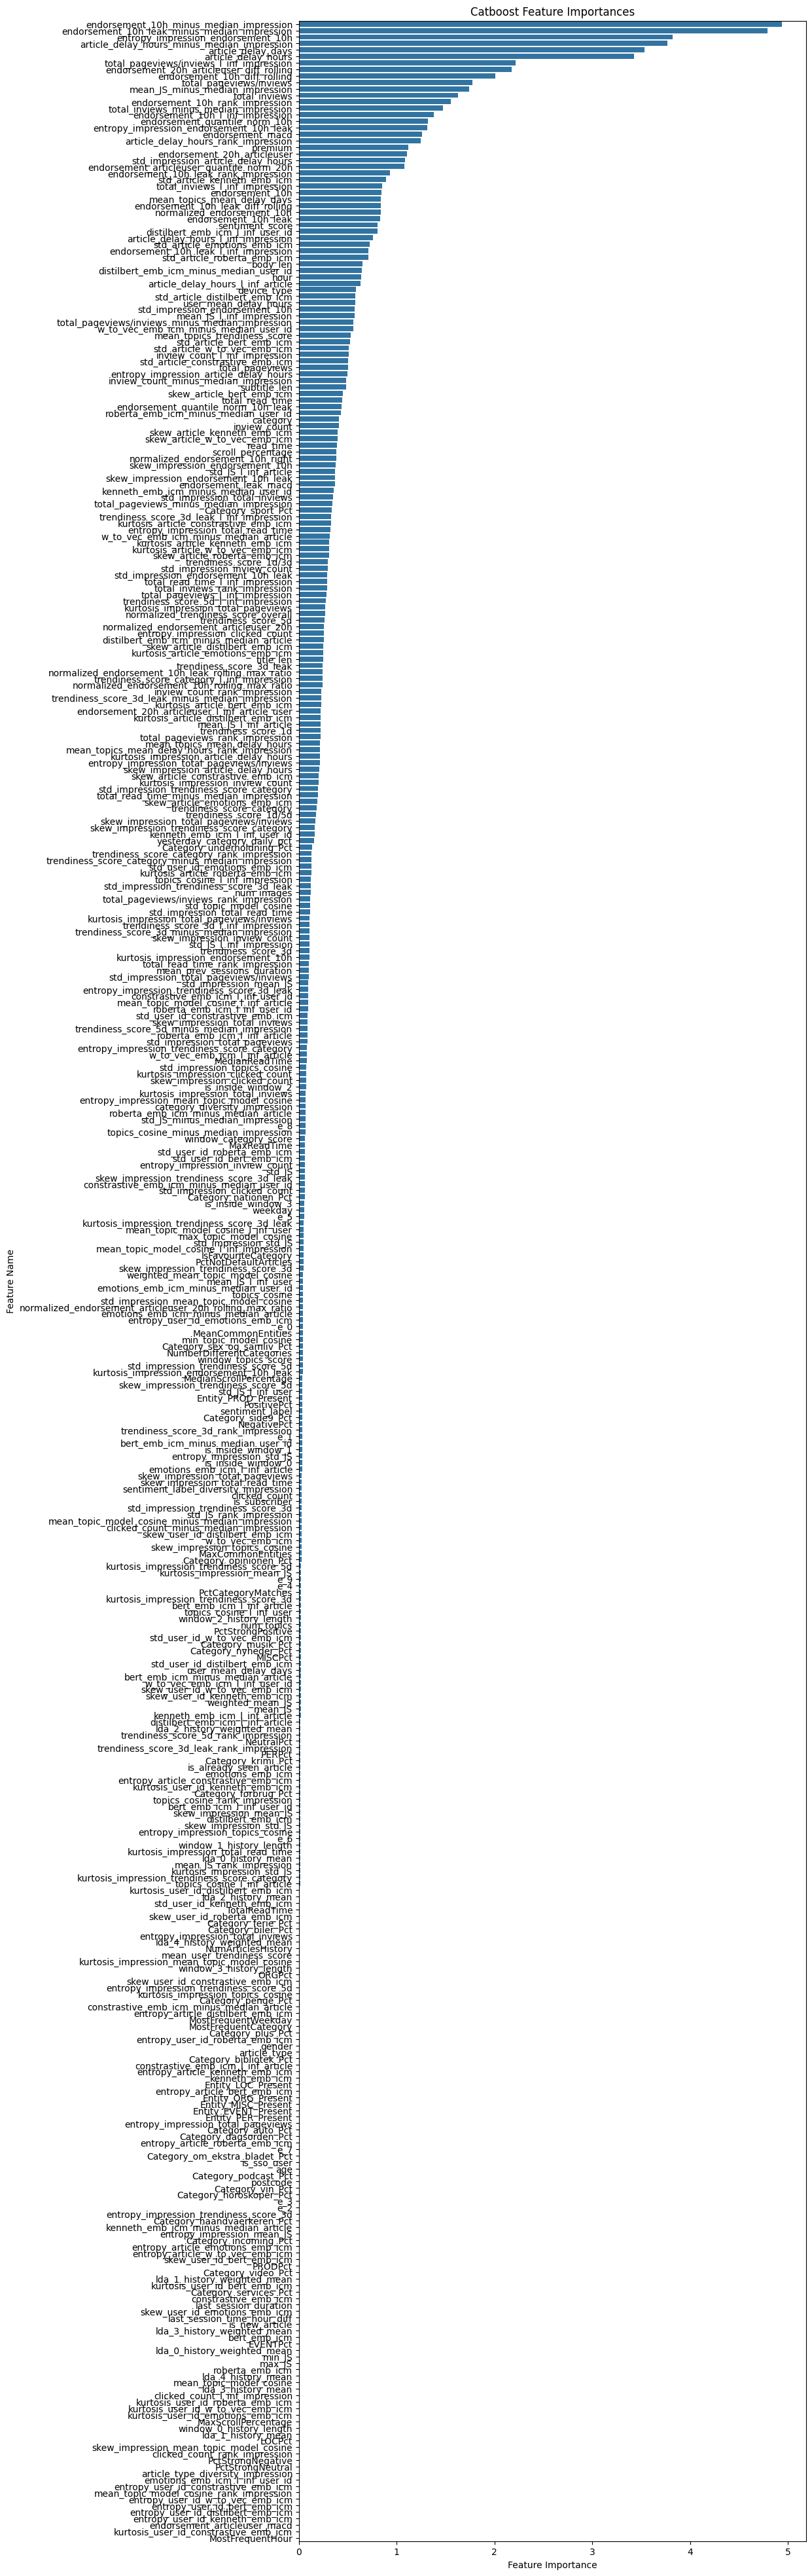

In [83]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 50))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X_train.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

# Evaluate

In [19]:
val_ds_path = preprocessing_path / 'preprocessing_validation_small_127'
val_info = read_json(val_ds_path / 'data_info.json')
val_ds = pl.read_parquet(val_ds_path / 'validation_ds.parquet')
val_ds.head(2)

impression_id,article,user_id,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,target,trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_ORG_Present,Entity_PER_Present,Entity_MISC_Present,Entity_LOC_Present,Entity_EVENT_Present,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct,…,Category_sex_og_samliv_Pct,Category_video_Pct,Category_nationen_Pct,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,weighted_mean_JS,mean_topic_model_cosine,min_topic_model_cosine,max_topic_model_cosine,std_topic_model_cosine,weighted_mean_topic_model_cosine,lda_0_history_mean,lda_1_history_mean,lda_2_history_mean,lda_3_history_mean,lda_4_history_mean,lda_0_history_weighted_mean,lda_1_history_weighted_mean,lda_2_history_weighted_mean,lda_3_history_weighted_mean,lda_4_history_weighted_mean
u32,i32,u32,i8,f32,f32,bool,i8,i8,bool,i8,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,u32,i16,i32,bool,bool,bool,bool,bool,bool,i8,f32,i16,bool,bool,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
152218924,9581248,1551110,1,48.0,null,false,2,null,false,0,70,1,16,true,140,0.993,"""Negative""",6,5,21,696,2,139,3359,false,true,false,false,true,false,1,0.5,-60,true,false,0.106195,…,0.0,0.0,0.04186,201.148834,159.946533,10.069286,244.269562,0.069767,4.055814,34,67,88,60,0,1,0,0,14,23,39,446,0.118492,0.751289,0.439512,0.99834,0.129263,0.751899,0.197715,0.151007,0.24822,0.20829,0.194768,0.196474,0.150314,0.241067,0.214967,0.197179
6023132,9781848,108751,2,9.0,null,false,2,null,false,0,283,5,7,false,142,0.9612,"""Negative""",2,3,15,337,3,0,0,false,true,true,false,true,true,0,1.423077,-6,true,false,0.235772,…,0.0,0.0,0.025478,258.912109,376.573792,5.160991,126.33223,1.038217,26.540127,395,320,116,46,1,0,0,0,118,370,97,11,0.181884,0.813657,0.513151,0.997972,0.111379,0.810134,0.19653,0.151019,0.209977,0.238965,0.20351,0.193723,0.15897,0.207682,0.236031,0.203595


In [20]:
val_features = pl.read_parquet(features_path / 'validation' / 'urm_ner_scores.parquet')
val_features.head(2)

impression_id,user_id,article,sum_RP3betaRecommender_ner_scores,sum_PureSVDItemRecommender_ner_scores,sum_ItemKNNCFRecommender_ner_scores,sum_MatrixFactorization_BPR_Cython_ner_scores,sum_P3alphaRecommender_ner_scores,max_RP3betaRecommender_ner_scores,max_PureSVDItemRecommender_ner_scores,max_ItemKNNCFRecommender_ner_scores,max_MatrixFactorization_BPR_Cython_ner_scores,max_P3alphaRecommender_ner_scores,mean_RP3betaRecommender_ner_scores,mean_PureSVDItemRecommender_ner_scores,mean_ItemKNNCFRecommender_ner_scores,mean_MatrixFactorization_BPR_Cython_ner_scores,mean_P3alphaRecommender_ner_scores
u32,u32,i32,f32,f32,f32,f64,f32,f32,f32,f32,f64,f32,f32,f32,f32,f64,f32
96791,22548,9783865,0.079666,0.085871,0.095643,1.714286,0.026414,0.111974,0.136606,0.111264,1.0,0.029971,0.05975,0.064403,0.071733,1.0,0.01981
96791,22548,9784591,0.464435,0.551501,0.643859,1.0,0.577347,1.0,1.0,1.0,1.0,1.0,0.597131,0.709073,0.827818,1.0,0.742303


In [21]:
val_ds = val_ds.join(val_features, on=['impression_id', 'user_id', 'article'], how='left')
val_ds.head(2)

impression_id,article,user_id,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,target,trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_ORG_Present,Entity_PER_Present,Entity_MISC_Present,Entity_LOC_Present,Entity_EVENT_Present,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct,…,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,weighted_mean_JS,mean_topic_model_cosine,min_topic_model_cosine,max_topic_model_cosine,std_topic_model_cosine,weighted_mean_topic_model_cosine,lda_0_history_mean,lda_1_history_mean,lda_2_history_mean,lda_3_history_mean,lda_4_history_mean,lda_0_history_weighted_mean,lda_1_history_weighted_mean,lda_2_history_weighted_mean,lda_3_history_weighted_mean,lda_4_history_weighted_mean,sum_RP3betaRecommender_ner_scores,sum_PureSVDItemRecommender_ner_scores,sum_ItemKNNCFRecommender_ner_scores,sum_MatrixFactorization_BPR_Cython_ner_scores,sum_P3alphaRecommender_ner_scores,max_RP3betaRecommender_ner_scores,max_PureSVDItemRecommender_ner_scores,max_ItemKNNCFRecommender_ner_scores,max_MatrixFactorization_BPR_Cython_ner_scores,max_P3alphaRecommender_ner_scores,mean_RP3betaRecommender_ner_scores,mean_PureSVDItemRecommender_ner_scores,mean_ItemKNNCFRecommender_ner_scores,mean_MatrixFactorization_BPR_Cython_ner_scores,mean_P3alphaRecommender_ner_scores
u32,i32,u32,i8,f32,f32,bool,i8,i8,bool,i8,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,u32,i16,i32,bool,bool,bool,bool,bool,bool,i8,f32,i16,bool,bool,f32,…,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f32,f32,f32,f32,f64,f32,f32,f32,f32,f64,f32
152218924,9581248,1551110,1,48.0,null,false,2,null,false,0,70,1,16,true,140,0.993,"""Negative""",6,5,21,696,2,139,3359,false,true,false,false,true,false,1,0.5,-60,true,false,0.106195,…,0,0,14,23,39,446,0.118492,0.751289,0.439512,0.99834,0.129263,0.751899,0.197715,0.151007,0.24822,0.20829,0.194768,0.196474,0.150314,0.241067,0.214967,0.197179,0.462672,0.356153,0.492452,3.5,0.674252,1.0,1.0,1.0,1.0,1.0,0.882752,0.861198,0.970147,1.0,0.895341
6023132,9781848,108751,2,9.0,null,false,2,null,false,0,283,5,7,false,142,0.9612,"""Negative""",2,3,15,337,3,0,0,false,true,true,false,true,true,0,1.423077,-6,true,false,0.235772,…,0,0,118,370,97,11,0.181884,0.813657,0.513151,0.997972,0.111379,0.810134,0.19653,0.151019,0.209977,0.238965,0.20351,0.193723,0.15897,0.207682,0.236031,0.203595,0.337981,0.295064,0.407492,2.2,0.241321,0.334423,0.382363,0.32098,1.0,0.187018,0.35092,0.348712,0.421253,1.0,0.17097


In [22]:
val_ds_pandas = val_ds.drop(['impression_id', 'article', 'user_id', 'impression_time']).to_pandas()

categorical_columns = val_info['categorical_columns']
val_ds_pandas[categorical_columns] = val_ds_pandas[categorical_columns].astype('category')

X_val = val_ds_pandas.drop(columns=['target'])
y_val = val_ds_pandas['target']

In [23]:
val_ds = val_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction'))
val_ds.select(['impression_id', 'target', 'prediction'])

impression_id,target,prediction
u32,i8,f64
152218924,0,0.007399
6023132,0,0.377946
98943105,0,0.242254
285361101,0,0.155667
280914651,0,0.009909
…,…,…
357503649,0,0.277262
129630616,0,0.018435
243313027,0,0.085117


In [24]:
evaluation_ds = val_ds.group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
evaluation_ds

impression_id,target,prediction
u32,list[i8],list[f64]
348531293,"[0, 0, … 0]","[0.036892, 0.11537, … 0.029732]"
48021678,"[0, 1, … 0]","[0.038006, 0.192586, … 0.123852]"
394662659,"[0, 0, … 0]","[0.118809, 0.011817, … 0.009344]"
42279091,"[0, 0, … 0]","[0.250448, 0.036428, … 0.007381]"
385812803,"[0, 0, … 0]","[0.012282, 0.022681, … 0.436193]"
…,…,…
399475344,"[0, 0, … 0]","[0.002863, 0.119527, … 0.003201]"
487646921,"[1, 0, … 0]","[0.017109, 0.192075, … 0.003194]"
419495818,"[0, 0, … 0]","[0.067122, 0.008753, … 0.026041]"


In [25]:
%%time

met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['prediction'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

CPU times: user 1min 45s, sys: 520 ms, total: 1min 45s
Wall time: 1min 48s


<MetricEvaluator class>: 
 {
    "auc": 0.6927058800913705,
    "mrr": 0.46446877006677517,
    "ndcg@5": 0.5195920785889891,
    "ndcg@10": 0.5697743996011575
}